<a href="https://colab.research.google.com/github/Saba-a11/Crypto/blob/main/EWMA_%26_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
! ls

airline_passengers.csv	sample_data


In [20]:
import numpy as np
import pandas as pd

In [21]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [22]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [23]:
# check if there are any missing value
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

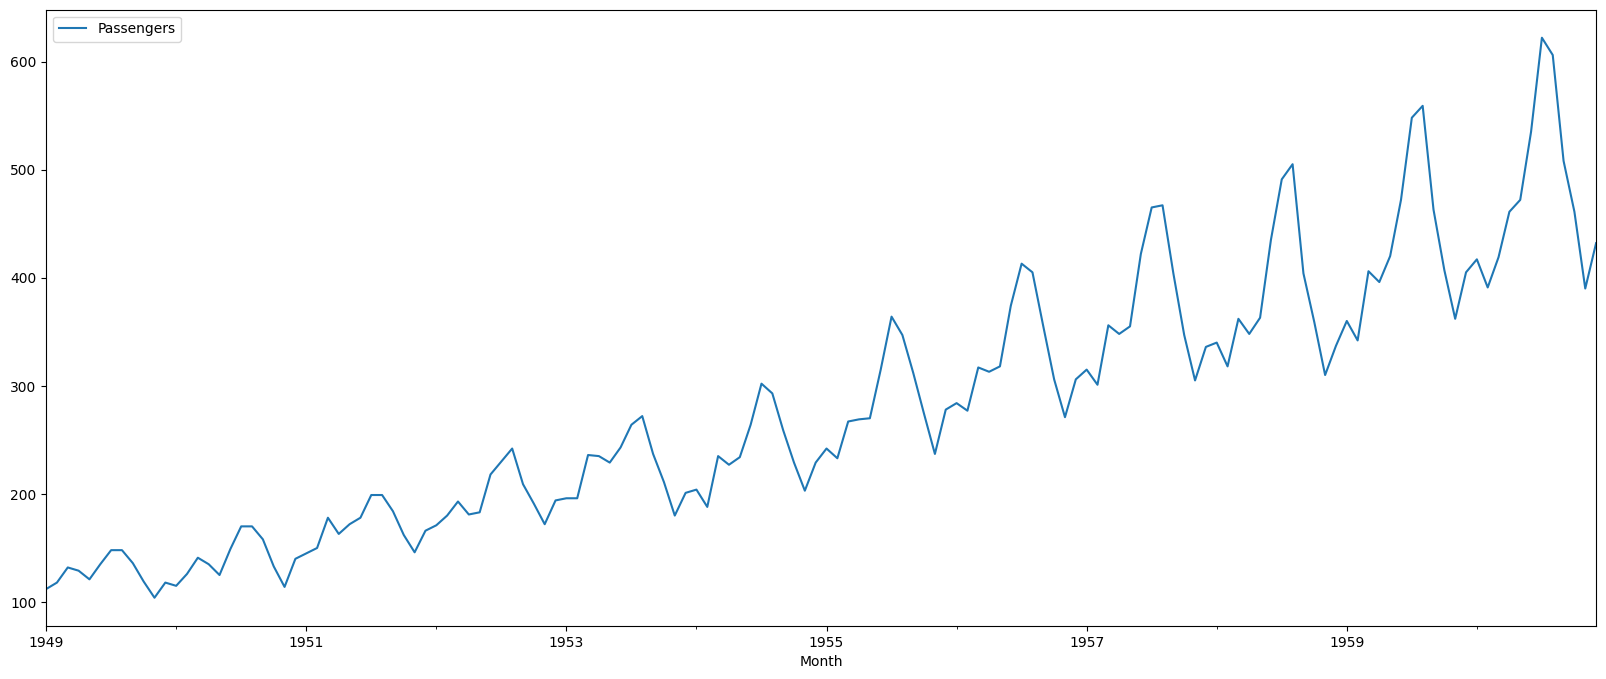

In [24]:
df.plot(figsize=(20, 8))

- This data set, there seem to be a **trend component** and **cyclical component**.

- The **trend component** means that the signal is generally going upwards.

- The **cyclical component** means that there's some periodicity where the same pattern repeats itself.

- The cyclical pattern is not a constant cyclical pattern.

- It is difficult to tell whether the trend is increasing linearly or if that is increasing over time or exponentially in time.

In [25]:
alpha = 0.2

In [32]:
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

<Axes: xlabel='Month'>

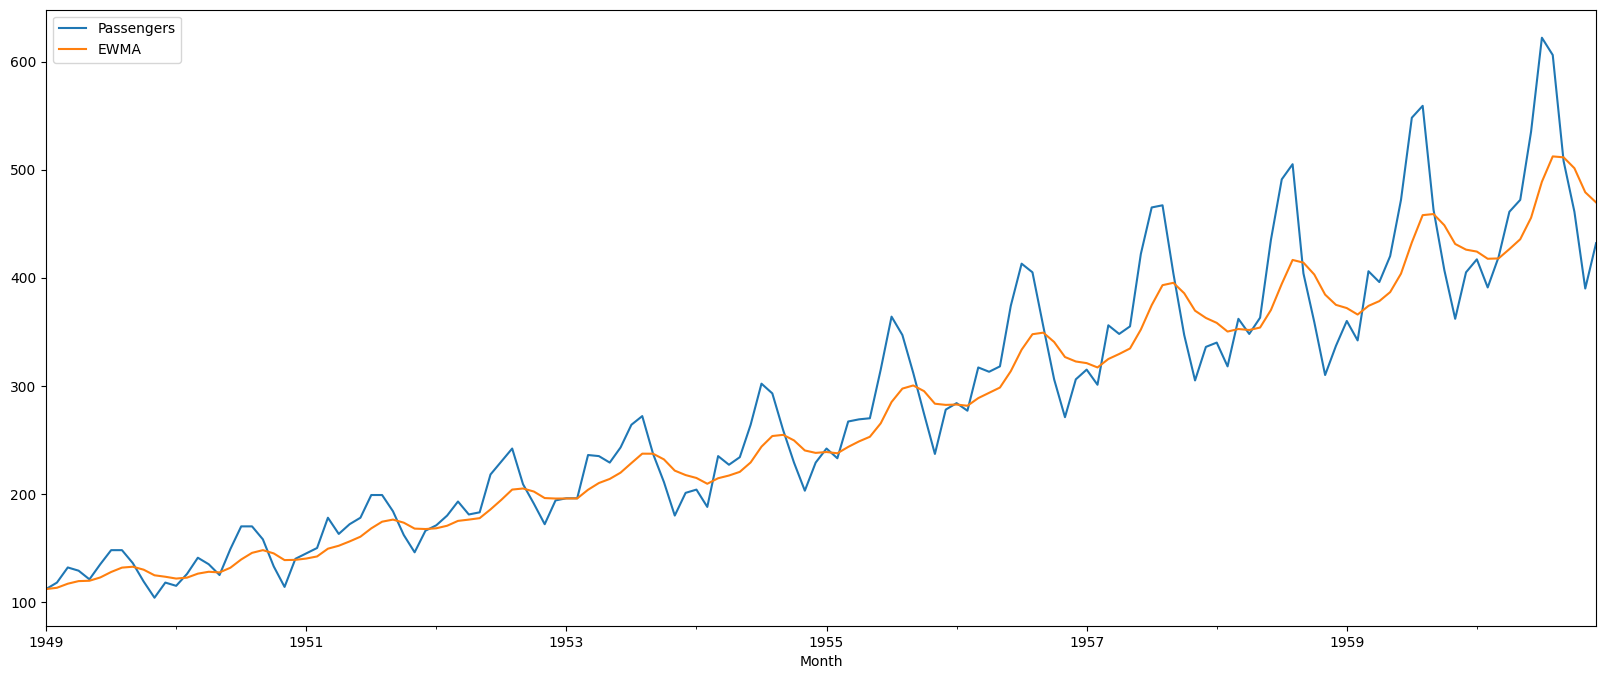

In [34]:
df.plot(figsize=(20, 8))

In [35]:
manual_ewma = []
for x in df["Passengers"].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)

df["manual"] = manual_ewma

<Axes: xlabel='Month'>

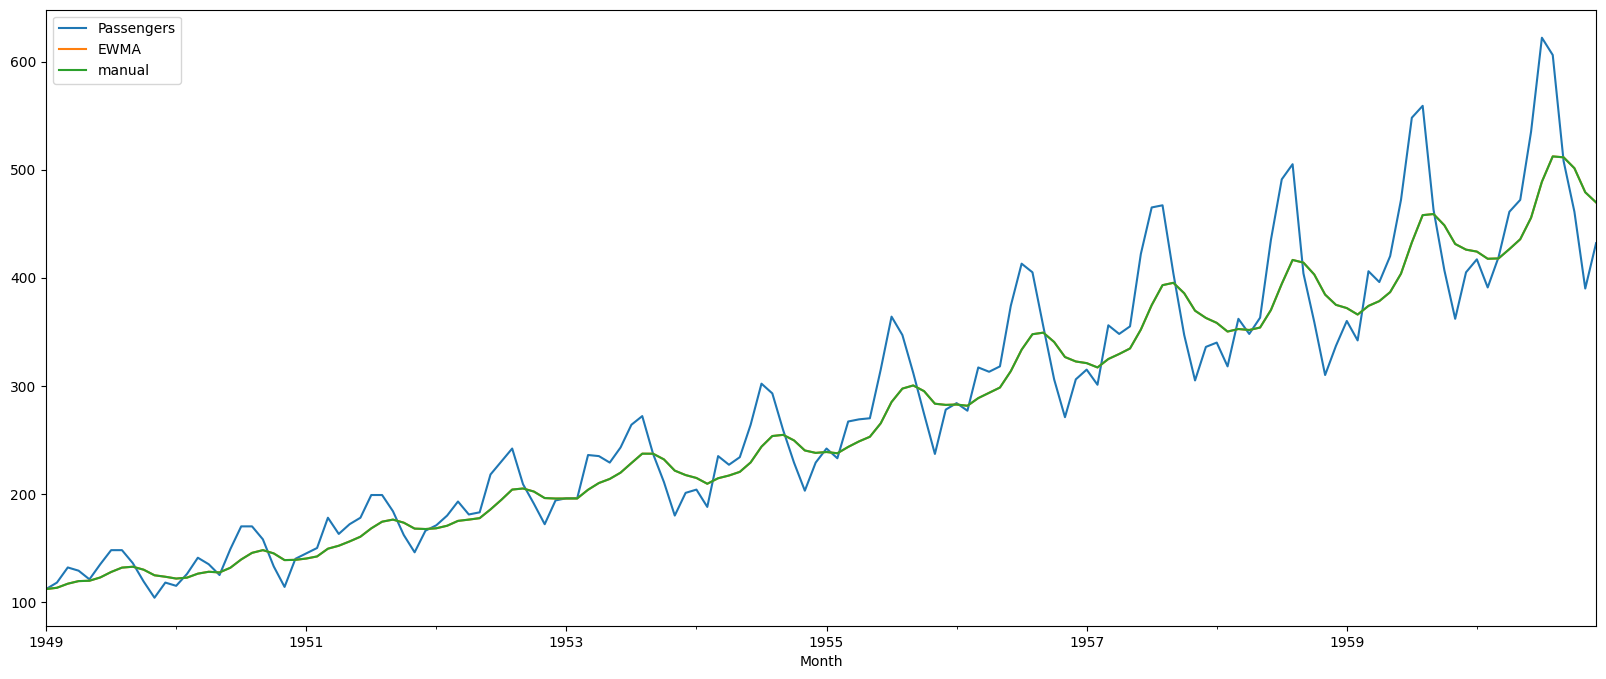

In [36]:
df.plot(figsize=(20, 8))

In [37]:
df.head()

,Passengers,EWMA,manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [38]:
df.drop("manual", axis=1, inplace=True)

In [39]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing